The goal of this notebook is an exploration, and implementation, of the Kropff and Treves 2008 model for grid cells. Below is a rough flowchart of the models' processes.

![FLOWCHART](KrTr2008.png)

Before we can get to the model, we have to simulate some basic data for testing, using a random walk. Specifically, it will be similar to the one described in the paper, in that it randomly bounces off of the arena walls. The simulation will output coordinate data (x and y), but can also be used to calculate velocity if desired

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

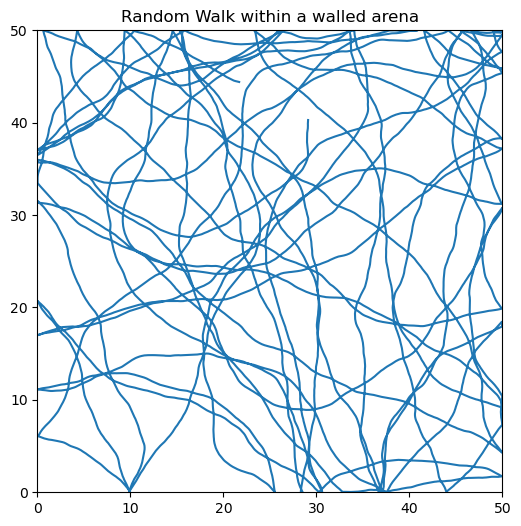

In [64]:
#Sim Parameters
aSize = 50
steps = 20000
speed = 0.1
thetaMax = 5

#Calculates vector using angle
def conv(ang):
        x = np.cos(np.radians(ang)) 
        y = np.sin(np.radians(ang)) 
        return x , y

def random_walk(aSize, steps, speed, thetaMax, plot=True):

    #random initial values
    x = [np.random.uniform(0, aSize)]
    y = [np.random.uniform(0, aSize)]
    theta = np.random.uniform(0, 360)

    #Actual random walk
    for step in range(steps-1):

        theta += np.random.uniform(-thetaMax,thetaMax)

        while (x[-1] + speed*conv(theta)[0] > aSize) or (x[-1] + speed*conv(theta)[0] < 0):
            theta = np.random.uniform(0,360)

        while (y[-1] + speed*conv(theta)[1] > aSize) or (y[-1] + speed*conv(theta)[1] < 0):
            theta = np.random.uniform(0,360)

        x.append(x[-1] + speed*conv(theta)[0])
        y.append(y[-1] + speed*conv(theta)[1])

        
    if plot:
        #Plotting setup
        fig, ax = plt.subplots()
        fig.set_size_inches((6,6))
        ax.set_xlim(xmin = 0, xmax=aSize)
        ax.set_ylim(ymin = 0, ymax=aSize)
        ax.set_title('Random Walk within a walled arena')
        ax.plot(x,y,'-')

        plt.show()

    x = np.asarray(x)
    y = np.asarray(y)

    return np.hstack((x.reshape((-1,1)), y.reshape((-1,1))))

coords = random_walk(aSize, steps, speed, thetaMax)

Cool! First up is the pre-synaptic neural layer. These neurons are not actually a part of the grid cells (Those are the post-synaptic neurons), but rather the input. For now, they will be place cells much as in the paper. Later on, once we know the model is working, we can try different inputs. 

To keep things simple, these place cells will have circular receptive fields. The firing rate will be between 0 and 1, with firing rate inversely proportional to the distance from center of the receptive fields.

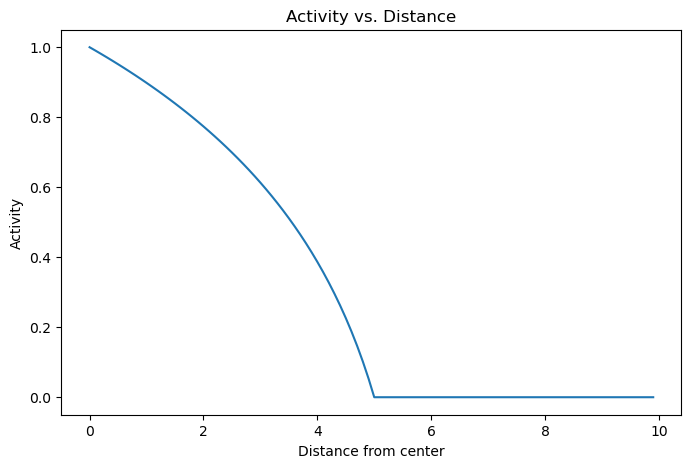

In [65]:
class placeCellNetwork():
    """
    Place cell model (What model)
    """
    def __init__(self, dim, C, R, mu=1.0, beta=0.0):
        """
        :param int dim: Dimension of data
        :param vector C: Center coordinates of the receptive fields
        :param float R: Radius of the receptive fields
        :param float mu: Maximum firing rate
        :param float beta: Minimum firing rate
        """
        self.C = np.asarray(C).reshape((-1,1,dim))
        self.R = R
        self.mu =  mu
        self.beta = beta
        self.dim = dim

    def calc_activity(self, L):
        """
        Calculates activity given a colum vector of coordinates
        :param vector C: Coordinates of the agents location, must be a Column Vector of shape (length, dim)
        """
        d = np.linalg.norm(self.C - np.asarray(L).reshape((-1,self.dim)), axis=2)
        d2 = np.copy(d)
        d2[d<=self.R] = (self.mu/np.log(self.R+1)) * np.log(-d[d<=self.R]+self.R+1) + self.beta
        d2[d>self.R] = self.beta
        return d2.T


pc = placeCellNetwork(1,[0],5)
X = np.arange(0,10,0.1)
act = pc.calc_activity(X)
fig, ax = plt.subplots()
fig.set_size_inches((8,5))
ax.plot(X, act[:,0])
ax.set_xlabel('Distance from center')
ax.set_ylabel('Activity')
ax.set_title('Activity vs. Distance')
plt.show()

Now to initialize the place cell network. In this case we'll just place them randomly around the arena with constant radius and not worry about overlap.

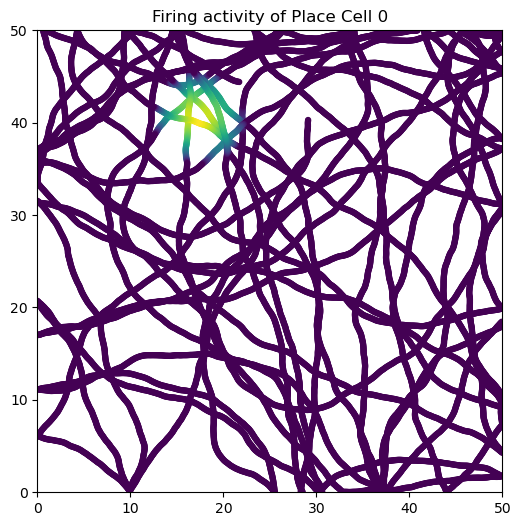

In [66]:
centers = np.random.uniform(0, aSize, (200,2)) #initialize centers randomly
placeCells = placeCellNetwork(2, centers, 5) 

activity = placeCells.calc_activity(coords) #Calculates activity

fig, ax = plt.subplots()
fig.set_size_inches((6,6))
ax.set_xlim(xmin = 0, xmax=aSize)
ax.set_ylim(ymin = 0, ymax=aSize)
ax.set_title('Firing activity of Place Cell %i' % 0)
ax.scatter(coords[:,0], coords[:,1], s=50, marker='.', c=activity[:,0])
plt.show()

In [67]:
#Interactive plot, run cell to see

@widgets.interact
def f(index=(0,199)):
    fig, ax = plt.subplots()
    fig.set_size_inches((6,6))
    ax.set_xlim(xmin = 0, xmax=aSize)
    ax.set_ylim(ymin = 0, ymax=aSize)
    ax.set_title('Firing activity of Place Cell %i' % index)
    ax.scatter(coords[:,0], coords[:,1], s=50, marker='.', c=activity[:,index])
    plt.show()

interactive(children=(IntSlider(value=99, description='index', max=199), Output()), _dom_classes=('widget-inte…

Here's a simple visualization of the Place Cell's activity over time.

In [68]:
@widgets.interact
def f(x=(0,steps-501)):
    plt.imshow(activity[x:x+500,:].T)
    plt.ylabel('Neuron')
    plt.xlabel('Step X +')

interactive(children=(IntSlider(value=9749, description='x', max=19499), Output()), _dom_classes=('widget-inte…

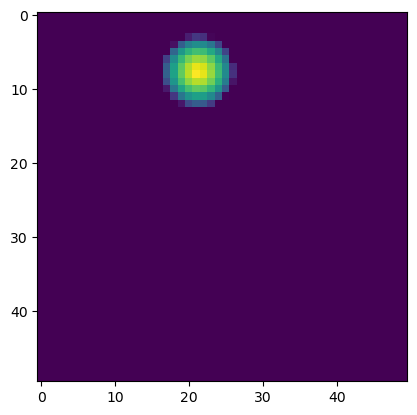

In [69]:
xs = np.arange(0.5,aSize+0.5, 1)
ys = np.arange(0.5,aSize+0.5, 1)

activityMatrix = np.zeros((len(ys), len(xs)))
i1 = 0
i2 = 0
for row in activityMatrix:
    for col in row:
        activityMatrix[i1][i2] = placeCells.calc_activity([xs[i1], ys[i2]])[0][4]
        i2+=1
    i2 = 0
    i1 += 1

plt.imshow(activityMatrix)

In [70]:
#Heaviside function for psi calculation, keep firing rate positive or 0
def heaviside(x):
    x2 = np.copy(x)
    x2[x<0] = 0
    x2[x==0] = 1/2
    x2[x>0] = 1
    return x2

To keep things as simple as possible, we'll start off with a small, 1-dimensional implementation. In this sim, the agent will simply walk between two walls

In [71]:
def random_walk_1d(speed, aSize, steps):
    x = np.random.uniform(0, aSize, steps)
    for step in range(steps-1):
        x[step] += speed
        if x[step] >= aSize:
            x[step] = aSize
            speed = -speed
        if x[step] <= 0:
            x[step] = 0
            speed = -speed
    return x

In [72]:
#Place cell params
N1 = 25
aSize = 15
steps = 1000000
speed = 0.6

pre_layer = placeCellNetwork(1, np.random.uniform(0, aSize, N1), 1)
obs = random_walk_1d(speed, aSize, steps)
r = pre_layer.calc_activity(obs) #Pre-syn activity

In [73]:
@widgets.interact
def f(x=(0,steps-101)):
    plt.imshow(r[x:x+100,:].T)
    plt.ylabel('Neuron')
    plt.xlabel('Step X +')

interactive(children=(IntSlider(value=499949, description='x', max=999899), Output()), _dom_classes=('widget-i…

In [78]:
#Default paramters from paper
N_mEC = 10
b1 = 0.1
b2 = b1/3
sat = 30 #Psi_Saturation
a0 = 0.1 * sat
s0 = 0.3
eps = 0.001 #epsilon

#Not from paper, have to adjust
b3 = 0.01
b4 = 0.1


#Training session length -> How many steps to run before updating weights
s_length = 10000

J = np.zeros((steps, N_mEC, N1))
J[0] = np.random.uniform(0.4, 0.6, (1, N_mEC, N1)) #Initialize Weight matrix randomly

#Indiviual neuron variables
# Column vectors: each row = variables for one step (each row of length N_mEc, each col of length steps)
r_act = np.zeros((steps, N_mEC))
r_inact = np.zeros((steps, N_mEC))
h = np.zeros((steps, N_mEC))
psi = np.zeros((steps, N_mEC))

#Network variables, each value = one step
g = np.zeros(steps)
theta = np.zeros(steps)
a = np.zeros(steps)
s = np.zeros(steps)

g[0] = 0.5

In [79]:
for t in range(steps-1):

    #h function
    h[t] = ((J[t]@r[t])/N1) 

    #Psi function
    psi[t] = sat * 2/np.pi * np.arctan(g[t]*(r_act[t]-theta[t])) * heaviside(r_act[t] - theta[t]) 

    #r act/inact funcs, responsible for fatigue dynamics
    r_act[t+1] = r_act[t] + b1*(h[t] - r_inact[t] - r_act[t])
    r_inact[t+1] = r_inact[t] + b2*(h[t] - r_inact[t])

    #a and s funcs
    if np.sum(psi[t]) == 0:
        a[t] = 0
        s[t] = 0
    else:
        a[t] = np.sum(psi[t])/N_mEC
        s[t] = (np.sum(psi[t])**2) / (N_mEC * np.sum(psi[t]**2))

    #theta and gain funcs
    theta[t+1] = theta[t] + b3 * (a[t] - a0)
    if theta[t+1] < 0:
        theta[t+1] = 0
    g[t+1] = g[t] + b4 * g[t] * (s[t] - s0)

    #Weights update
    if t>s_length:
        J[t+1] = J[t] + eps*(psi[t].reshape((-1,1))@r[t].reshape((1,-1)) - np.mean(psi[t-s_length:t+1], axis=0).reshape((-1,1))@np.mean(r[t-s_length:t+1], axis=0).reshape((1,-1)))
    else:
        J[t+1] = J[t] + eps*(psi[t].reshape((-1,1))@r[t].reshape((1,-1)) - np.mean(psi[:t+1], axis=0).reshape((-1,1))@np.mean(r[:t+1], axis=0).reshape((1,-1)))

In [8]:
def h_update(J, r, N1):
    return ((J@r)/N1) 

def psi_update(sat, g, r_act, theta):
    return sat * 2/np.pi * np.arctan(g*(r_act-theta)) * heaviside(r_act - theta)

def fatigue_update(r_act, r_inact, h, b1, b2):
    return r_act + b1*(h - r_inact - r_act), r_inact + b2*(h - r_inact)

def as_update(psi, N_mEC):
    if np.sum(psi) == 0:
        return 0, 0
    else:
        return np.sum(psi)/N_mEC, (np.sum(psi)**2) / (N_mEC * np.sum(psi**2))

def tg_update(theta, g, b3, b4, a, a0, s, s0):
    return theta + b3 * (a - a0), g + b4 * g * (s - s0)

def weights_update(J, eps, psi, r):
    return J + eps*(psi.reshape((-1,1))@r.reshape((1,-1)) - np.mean(psi) * np.mean(r))

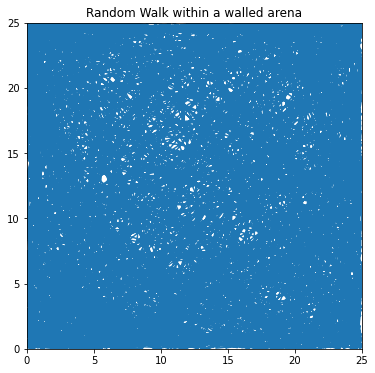

In [307]:
#Default paramters from paper
N1 = 200
N_mEC = 30
b1 = 0.1
b2 = b1/3
sat = 30 #Psi_Saturation
a0 = 0.1 * sat
s0 = 0.3
eps = 0.001 #epsilon

#Not from paper, have to adjust
b3 = 0.1
b4 = 0.1

#Sim parameters
aSize = 25
steps = 40000
speed = 0.5
thetaMax = 5

#Training session length -> How many steps to run before updating weights
s_length = 5

J = np.zeros((steps, N_mEC, N1))
J[0] = np.random.uniform(0.3, 0.7, (1, N_mEC, N1)) #Initialize Weight matrix randomly
pre_layer = placeCellNetwork(2, np.random.uniform(0, aSize, (N1,2)), 2.5 , 1, 0.1)
obs = random_walk(aSize, steps, speed, thetaMax, True)
r = pre_layer.calc_activity(obs) #Pre-syn activity

#Indiviual neuron variables
# Column vectors: each row = variables for one step (each row of length N_mEc, each col of length steps)
r_act = np.zeros((steps, N_mEC))
r_inact = np.zeros((steps, N_mEC))
h = np.zeros((steps, N_mEC))
psi = np.zeros((steps, N_mEC))

#Network variables, each value = one step
g = np.zeros(steps)
theta = np.zeros(steps)
a = np.zeros(steps)
s = np.zeros(steps)

g[0] = 0.5

In [308]:
for t in range(steps-1):

    #h function
    h[t] = ((J[t]@r[t])/N1) 

    #Psi function
    psi[t] = sat * 2/np.pi * np.arctan(g[t]*(r_act[t]-theta[t])) * heaviside(r_act[t] - theta[t]) 

    #r act/inact funcs, responsible for fatigue dynamics
    r_act[t+1] = r_act[t] + b1*(h[t] - r_inact[t] - r_act[t])
    r_inact[t+1] = r_inact[t] + b2*(h[t] - r_inact[t])

    #a and s funcs
    if np.sum(psi[t]) == 0:
        a[t] = 0
        s[t] = 0
    else:
        a[t] = np.sum(psi[t])/N_mEC
        s[t] = (np.sum(psi[t])**2) / (N_mEC * np.sum(psi[t]**2))

    #theta and gain funcs
    theta[t+1] = theta[t] + b3 * (a[t] - a0)
    if theta[t+1] < 0:
        theta[t+1] = 0
    g[t+1] = g[t] + b4 * g[t] * (s[t] - s0)

    #Weights update
    J[t+1] = J[t] + eps*(psi[t].reshape((-1,1))@r[t].reshape((1,-1)) - np.mean(psi[:t+1], axis=0).reshape((-1,1))@np.mean(r[:t+1], axis=0).reshape((1,-1)))

In [278]:
np.mean(psi[:5], axis=0).reshape((-1,1))@np.mean(r[:5], axis=0).reshape((1,-1))


(30, 100)

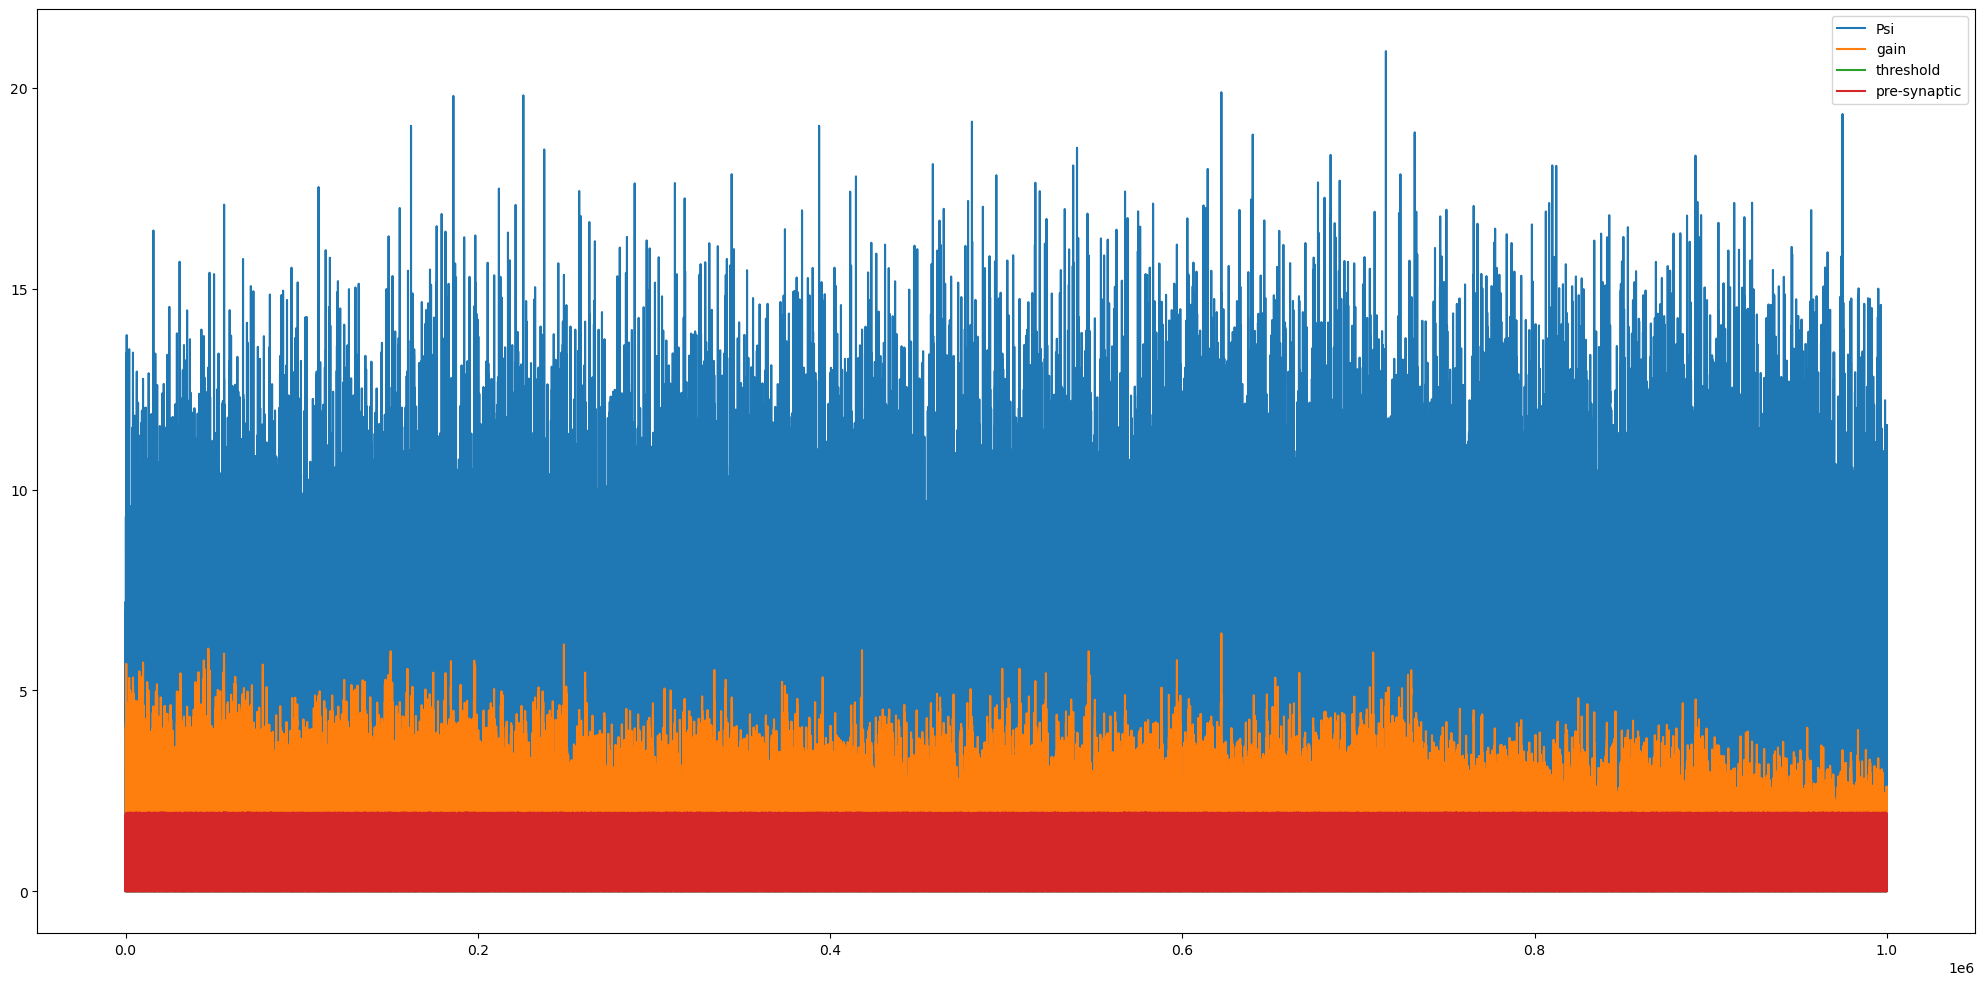

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches((25,12))
ax.plot(np.arange(steps), np.mean(psi, axis=1), label='Psi')
ax.plot(np.arange(steps), g/15, label='gain')
ax.plot(np.arange(steps), theta, label='threshold')
ax.plot(np.arange(steps), np.mean(r, axis=1)*10, label='pre-synaptic')
ax.legend()
plt.show()

In [319]:
np.mean(r, axis=1).shape

(40000,)

In [61]:
@widgets.interact
def f(x=(0,steps)):
    fig, ax = plt.subplots()
    fig.set_size_inches((25,12))
    ax.plot(np.arange(N_mEC),psi[x])
    ax.plot(np.arange(N_mEC),psi[x])
    plt.show()

interactive(children=(IntSlider(value=500000, description='x', max=1000000), Output()), _dom_classes=('widget-…

In [80]:
@widgets.interact
def f(x=(0,steps-501)):
    fig, ax = plt.subplots()
    fig.set_size_inches((15,32))
    ax.imshow(psi[x:x+500,:].T)

interactive(children=(IntSlider(value=499749, description='x', max=999499), Output()), _dom_classes=('widget-i…

In [86]:
@widgets.interact
def f(x=(0, steps-501)):
    fig, ax = plt.subplots()
    fig.set_size_inches((7,6))
    ax.imshow(J[x])

interactive(children=(IntSlider(value=499749, description='x', max=999499), Output()), _dom_classes=('widget-i…

In [286]:
xs = np.arange(0.5,aSize+0.5, 1)
ys = np.arange(0.5,aSize+0.5, 1)

h2 = []

for i1 in range(aSize):
    for i2 in range(aSize):
        h2.append(pre_layer.calc_activity([xs[i1], ys[i2]]))


In [287]:
h2

[array([[0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 2.09634337, 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0

In [268]:
J[-1]

#for t in range(aSize*aSize - 1):

    #h function
    #h[t] = ((J[t]@r[t])/N1) 

    #Psi function
    # psi[t] = sat * 2/np.pi * np.arctan(g[t]*(r_act[t]-theta[t])) * heaviside(r_act[t] - theta[t]) 

    # #r act/inact funcs, responsible for fatigue dynamics
    # r_act[t+1] = r_act[t] + b1*(h[t] - r_inact[t] - r_act[t])
    # r_inact[t+1] = r_inact[t] + b2*(h[t] - r_inact[t])

    # #a and s funcs
    # if np.sum(psi[t]) == 0:
    #     a[t] = 0
    #     s[t] = 0
    # else:
    #     a[t] = np.sum(psi[t])/N_mEC
    #     s[t] = (np.sum(psi[t])**2) / (N_mEC * np.sum(psi[t]**2))

    # #theta and gain funcs
    # theta[t+1] = theta[t] + b3 * (a[t] - a0)
    # if theta[t+1] < 0:
    #     theta[t+1] = 0
    # g[t+1] = g[t] + b4 * g[t] * (s[t] - s0)

    # #Weights update
    # J[t+1] = J[t] + eps*(psi[t].reshape((-1,1))@r[t].reshape((1,-1)) - np.mean(psi[:t+1]) * np.mean(r[:t+1]))

array([[-0.00409745,  2.3412982 ,  0.02439649, ...,  1.4416002 ,
        -0.07564935,  2.46910587],
       [-0.53481808,  0.92496108, -0.3824604 , ...,  0.69463484,
        -0.44869206,  0.73644481],
       [ 0.14049095,  2.2086334 ,  0.04890604, ...,  1.28312552,
         0.0251244 ,  2.1290832 ],
       ...,
       [-0.07514048,  1.39781333,  0.08718766, ...,  0.77215865,
        -0.20767165,  1.74558125],
       [ 0.28459198,  2.98074575,  0.1421397 , ...,  1.48077598,
         0.59321571,  3.19137486],
       [-0.39940482,  1.10404163, -0.17268943, ...,  1.11300965,
        -0.31430542,  1.34008409]])